# Interpolate Generated images

In [1]:
import datetime
from pathlib import Path
import torch.distributions as dist
import torch
import os
from ipywidgets import interact, widgets
from IPython.display import display
import matplotlib.pyplot as plt
import warnings
from PIL import Image
from torchvision.utils import save_image, make_grid

checkpoint_path = "TODO add checkpoint path here"

folder_time_format = "%Y%m%d-%H%M%S"
current_run_name = f"{datetime.datetime.now().strftime(folder_time_format)}_cevae"
work_dir = Path("./output/logs") / Path(current_run_name)
if not os.path.exists(work_dir):
    os.makedirs(work_dir)

output_dir = Path(work_dir) / Path("interpolated")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
use_cm = True

In [2]:
from sdo.sood.algorithms.ce_vae import ceVAE
    
cevae_algo = ceVAE.load_from_checkpoint(
            checkpoint_path, work_dir=work_dir)

In [3]:
import numpy as np
def compute_z(mu_path, std_path, n_samples=1):
    mu = torch.load(mu_path)
    std = torch.load(std_path)
    p = torch.distributions.Normal(mu, std)
    z = p.rsample((n_samples,))
    return z

# https://github.com/iconix/pytorch-text-vae/blob/master/pytorchtextvae/interpolate.py
# https://pytorch.org/docs/stable/generated/torch.lerp.html#torch.lerp
def lerp(val, low, high):
    return low + (high - low) * val

def lerp2(val, low, high):
    assert val <=1
    assert val >= 0
    return (1.0-val) * low + val * high

def generate_img(ce_vae, z, with_cm=False):
    pred = ce_vae.model.decode(z.to(ce_vae.device)).cpu()
    grid = make_grid(pred, normalize=True, scale_each=True, value_range=(-1.0, 1.0))
    ndarr = grid.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to("cpu", torch.uint8).numpy()
    
    if with_cm:
        from sunpy.visualization.colormaps import cm
        m = cm.cmlist.get('sdoaia%d' % int(171))
        v = np.squeeze(ndarr[:, :, 0])
        v = m(v)
        v = (v[:, :, :3]*255).astype(np.uint8)
        im = Image.fromarray(v)
    else:
        im = Image.fromarray(ndarr)
    
    return im



def display_z(idx):
    im = preds[idx]
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.imshow(im, cmap="gray")
    
def show_grid(imgs, ncols=8, channel="171"):
    nrows=int(len(imgs)/ncols)
    if nrows <= 0:
        nrows = 1
        ncols = len(imgs)
    fix, axs = plt.subplots(figsize=(ncols*2, nrows*2), ncols=ncols, nrows=nrows) #(15.5, 2 * nrows)
    row_index = 0
    for i, img in enumerate(imgs):
        col = i % ncols
        if i != 0 and i % ncols == 0:
            row_index = row_index + 1
        axs[row_index, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        axs[row_index, col].imshow(img)
        
    plt.tight_layout(pad=0.0)
    plt.show()

## Interpolating Z for Solar Max to Min

In [4]:
mu_min_path = "./data/reconstructions/20140515-210612_171A_mu.pt"
mu_max_path = "./data/reconstructions/20190515-091210_171A_mu.pt"
std_min_path = "./data/reconstructions/20140515-210612_171A_std.pt"
std_max_path = "./data/reconstructions/20190515-091210_171A_std.pt"

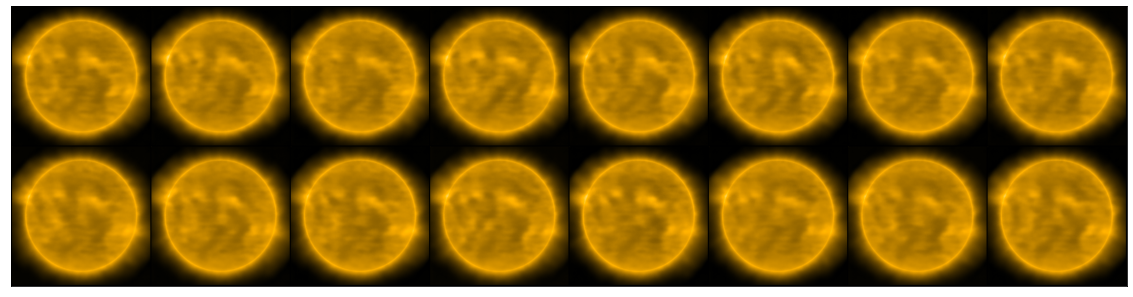

In [5]:
z = compute_z(mu_min_path, std_min_path, n_samples=16)
im = generate_img(cevae_algo, z, with_cm=use_cm)

fig, ax = plt.subplots(figsize=(20, 9))
ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
ax.imshow(im, cmap="gray")

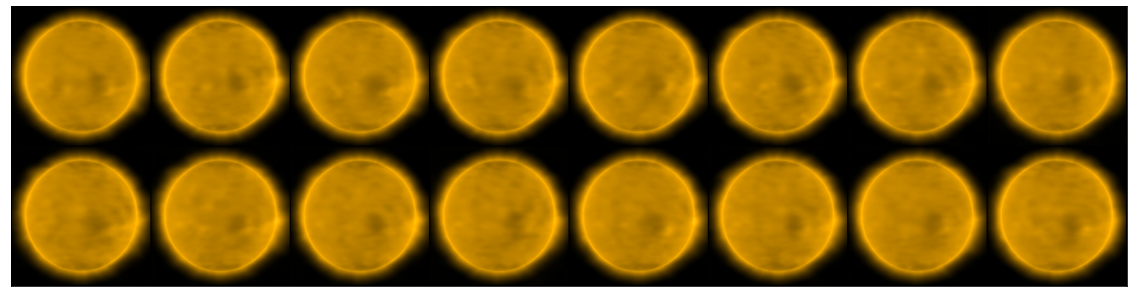

In [6]:
z = compute_z(mu_max_path, std_max_path, n_samples=16)
im = generate_img(cevae_algo, z, with_cm=use_cm)

fig, ax = plt.subplots(figsize=(20, 9))
ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
ax.imshow(im, cmap="gray")

In [7]:
import torch.nn as nn
mse = nn.MSELoss()

z_min = compute_z(mu_min_path, std_min_path)
z_max = compute_z(mu_max_path, std_max_path)

preds = []
steps = 16
for i in range(0, steps):
    t = i * 1.0 / (steps - 1)
    z = lerp(t, z_min, z_max)
    im = generate_img(cevae_algo, z, with_cm=True)
    preds.append(im)

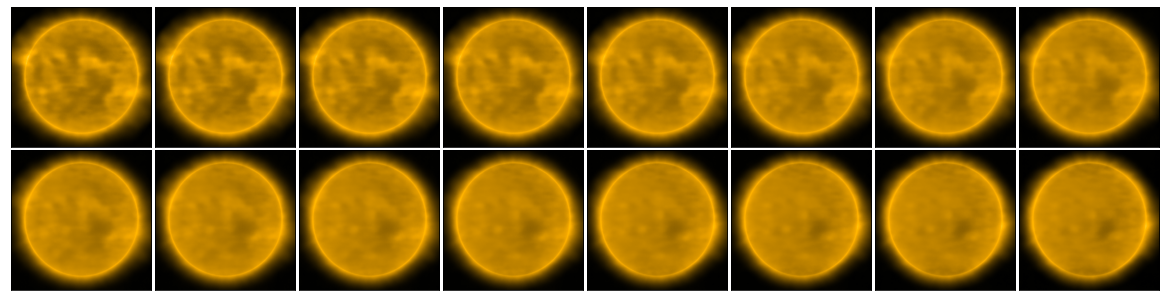

In [8]:
show_grid(preds)

In [10]:
%%capture
%matplotlib inline

In [11]:
interact(display_z, idx=widgets.IntSlider(min=0, max=len(preds)-1, step=1, value=1));

interactive(children=(IntSlider(value=1, description='idx', max=15), Output()), _dom_classes=('widget-interact…

## Solar Max

In [12]:
mu_min_path = "./data/reconstructions/20140515-210612_171A_mu.pt"
mu_max_path = "./data/reconstructions/20140520-113612_171A_mu.pt"
std_min_path = "./data/reconstructions/20140515-210612_171A_std.pt"
std_max_path = "./data/reconstructions/20140520-113612_171A_std.pt"

use_cm = True

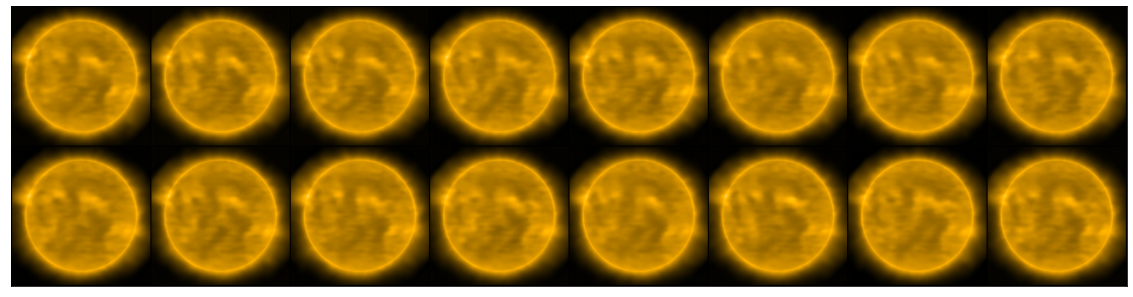

In [13]:
z = compute_z(mu_min_path, std_min_path, n_samples=16)
im = generate_img(cevae_algo, z, with_cm=use_cm)

fig, ax = plt.subplots(figsize=(20, 9))
ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
ax.imshow(im, cmap="gray")

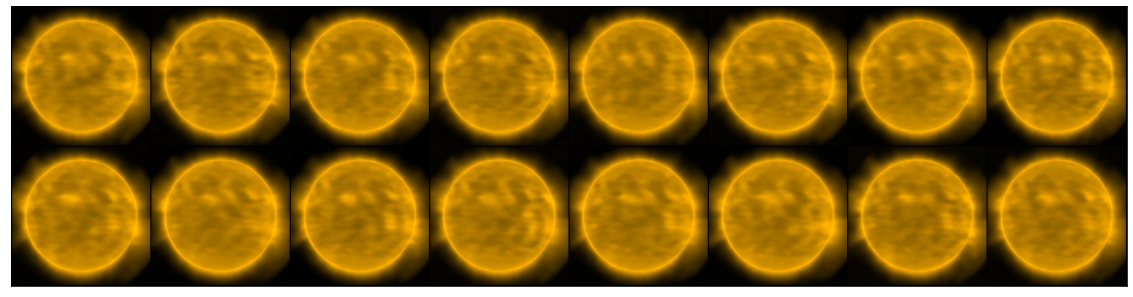

In [14]:
z = compute_z(mu_max_path, std_max_path, n_samples=16)
im = generate_img(cevae_algo, z, with_cm=use_cm)

fig, ax = plt.subplots(figsize=(20, 9))
ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
ax.imshow(im, cmap="gray")

In [15]:
import torch.nn as nn
mse = nn.MSELoss()

z_min = compute_z(mu_min_path, std_min_path)
z_max = compute_z(mu_max_path, std_max_path)

preds = []
steps = 16
for i in range(0, steps):
    t = i * 1.0 / (steps - 1)
    z = lerp(t, z_min, z_max)
    im = generate_img(cevae_algo, z, with_cm=True)
    preds.append(im)

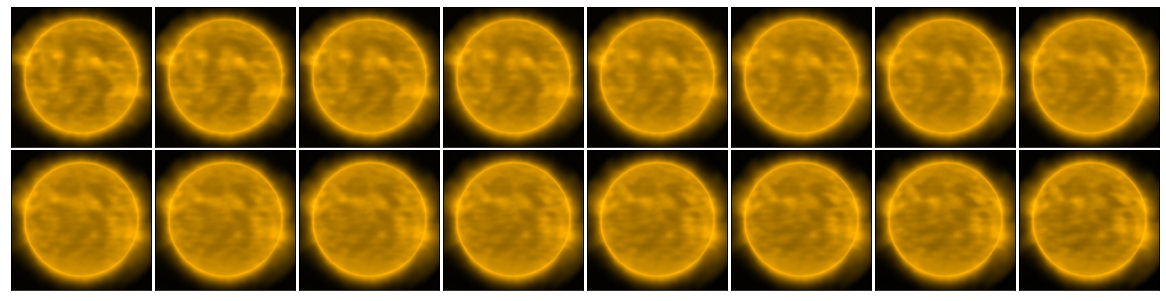

In [16]:
show_grid(preds)

## Interpolating Mu and Std for Solar Max

In [17]:
mu_min, std_min  = torch.load(mu_min_path), torch.load(std_min_path)
mu_max, std_max  = torch.load(mu_max_path), torch.load(std_max_path)


preds = []
steps = 16
for i in range(0, steps):
    t = i * 1.0 / (steps - 1)
    mu_k = lerp(t, mu_min, mu_max)
    std_k = lerp(t, std_min, std_max)
    p = torch.distributions.Normal(mu_k, std_k)
    z = p.rsample((1,))
    im = generate_img(cevae_algo, z, with_cm=True)
    preds.append(im)

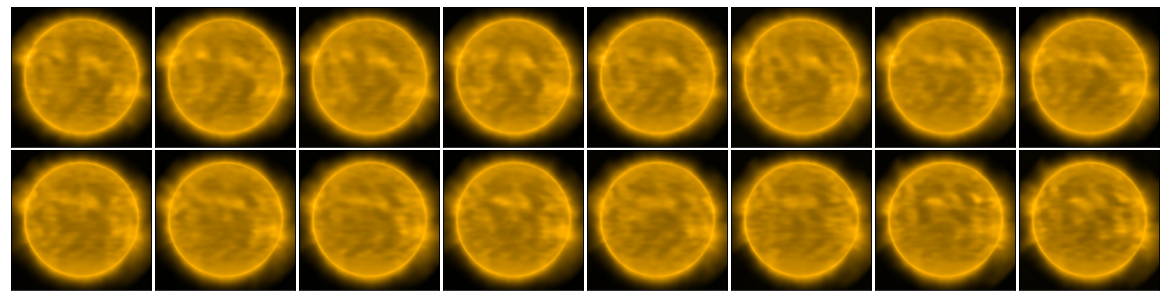

In [18]:
show_grid(preds)